In [1]:
import nltk
import nlp
import cupy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
from nltk.tokenize import word_tokenize
from nltk import ngrams
import random
from scipy.stats import norm
dat = nlp.load_dataset('cnn_dailymail', '1.0.0')

In [2]:
n_articles = 500
n = 1

In [3]:
articles = dat['train']['article'][:n_articles]
print('**SAMPLE**')
print(articles[0][:500])

tmp = [word_tokenize(article) for article in articles]
tmp = [item.lower() for sublist in tmp for item in sublist]
corpus = ' '.join(tmp)
text = list(ngrams(tmp, n))

freqs_dict = Counter()
for tup in text:
    freqs_dict[tup] += 1

**SAMPLE**
It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of che


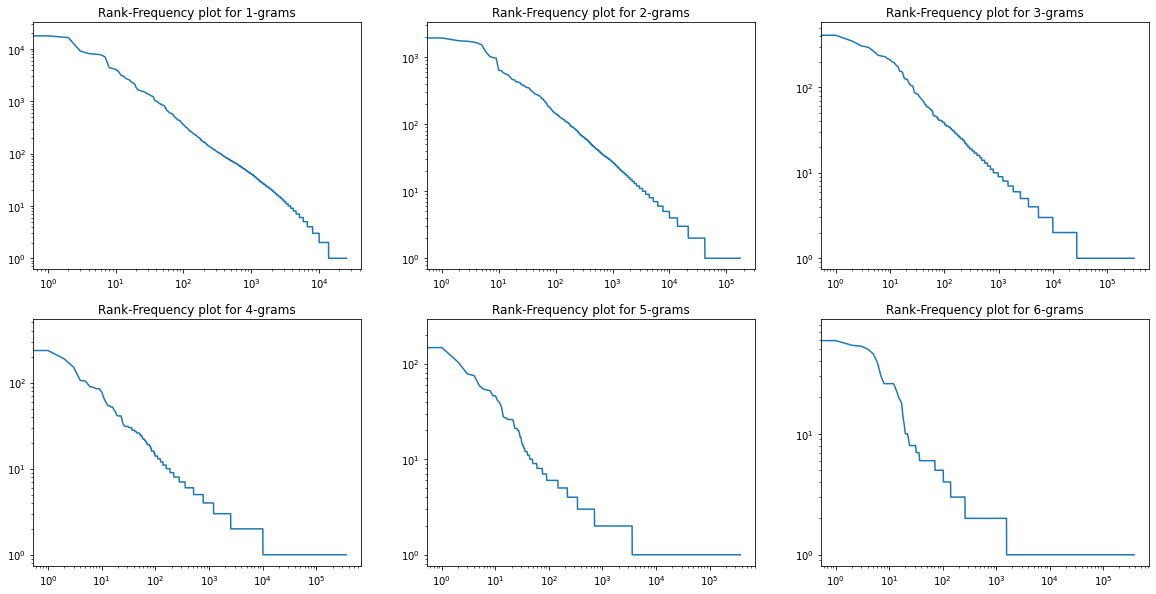

In [4]:
plt.figure(figsize=(20,10))
for i in range(1,7):
    tmp_text = list(ngrams(tmp, i))
    tmp_freqs_dict = Counter()
    for tup in tmp_text:
        tmp_freqs_dict[tup] += 1
    plt.subplot(2,3,i)
    plt.plot([x[1] for x in tmp_freqs_dict.most_common()])
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Rank-Frequency plot for {i}-grams')
plt.show()

The Rank-Frequency plot follows Zipf's Law for all *n*-grams, assuming a reasonable *n* is chosen.

Since most activation functions don't work well with power law-distributed data, we map each token to a value on a normal distribution according to its relative frequency in the dataset. In other words, very frequent tokens will have values close to zero while very infrequent tokens will lie on the tails.

We'll use single words as tokens.

In [5]:
freqs = np.array([x[1] for x in freqs_dict.most_common()])
assignment_og = [x[0] for x in freqs_dict.most_common()]
rel_freqs = freqs / sum(freqs)
norm_sample = np.random.normal(size=len(rel_freqs))
pdf_sample = norm.pdf(norm_sample.get())
new_idx = np.flip(np.argsort(pdf_sample))
int_mapping = {assignment_og[i]:norm_sample[idx] for i,idx in enumerate(new_idx)}
reverse_int_mapping = {v.item():k for k,v in int_mapping.items()}

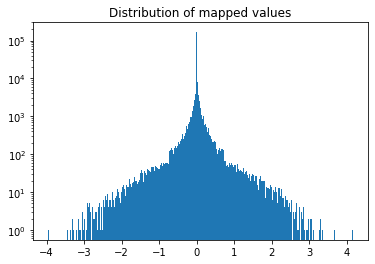

In [6]:
mapped_probabilities = np.asarray([int_mapping[tup] for tup in text])
plt.hist(mapped_probabilities.get(), bins=1000)
plt.yscale('log')
plt.title('Distribution of mapped values')
plt.show()

In [7]:
# scaled = (unscaled - unscaled.mean())/unscaled.std()
# plt.hist(scaled.get(), bins=300)
# plt.title('Distribution of (scaled) mapped values')
# plt.show()
# scaled = unscaled

In [8]:
n_reservoir = 1250
n_inputs = 5
n_outputs = 1
n_layers = 1
density = 0.05
input_density = 1
leaky_rate = .1
connectivity = 'close'
scheme = 'uniform'
M = 50

In [9]:
if n_inputs > 1:
    x = []
    for i in range(len(mapped_probabilities)-n_inputs+1):
        x.append(mapped_probabilities[i:i+n_inputs])
else:
    x = scaled
x = np.asarray(x)

train_test_split = 0.7
num_train = round(len(x) * train_test_split)
train_x = x[:num_train]
test_x = x[num_train:]

In [10]:
def generate_weight_matrix(n_inputs, n_outputs, density, connectivity, scheme, M=0):
    n = n_inputs * n_outputs
    if connectivity == 'close':
        r = -1 + 2 * np.random.rand(n_inputs, n_outputs)
    elif connectivity == 'larger':
        r = -5 + 10 * np.random.rand(n_inputs, n_outputs)
    elif connectivity == 'smaller':
        r = -.5 + np.random.rand(n_inputs, n_outputs)
    else:
        sys.exit('Invalid connectivity parameter')

    if scheme == 'uniform':
        W = np.random.rand(n_inputs, n_outputs) < density
    elif scheme == 'erdos-renyi':
        if M == 0:
            M = np.random.randint(1, n)
        W = np.zeros((n_inputs, n_outputs))
        for i in range(M):
            not_done = True
            while not_done:
                i = np.random.randint(1, n_inputs)
                j = np.random.randint(1, n_outputs)
                if W[i,j] == 0:
                    W[i,j] = 1
                    not_done = False
    else:
        sys.exit('Invalid scheme parameter')

    return np.multiply(W, r)

class layer:        
    def __init__(self, n_reservoir, n_inputs, n_outputs, density, input_density, 
                 connectivity, scheme, is_first_layer=False, leaky_rate=None, M=0):
        self.Win = -.1 + .2*np.random.rand(n_inputs,n_reservoir)
        # self.Win = (-.1 + .2*np.random.rand(n_inputs,n_reservoir)) * 10
        self.W = generate_weight_matrix(n_reservoir, n_reservoir, density, connectivity, scheme, M)
        scale = 1/self.W.max()
        self.W = self.W / scale

        self.x = np.expand_dims(np.zeros(n_reservoir), 1)
        self.a = leaky_rate
        self.D = []
            
    def update(self, u):
        recursive_influence = np.dot(self.W, self.x)
        if len(u.shape) == 1:
            inward_influence = np.dot(self.Win.T, np.expand_dims(u,1))
        else:
            inward_influence = np.dot(self.Win.T, u)
        if not self.a is None:
            recursive_influence = self.a * recursive_influence
            inward_influence = (1 - self.a) * inward_influence
            
        
        total_influence = recursive_influence + inward_influence
        self.x = np.tanh(total_influence)
        # self.x =  (total_influence > 0) * total_influence #+\
            # (total_influence < 0) * total_influence * 0.1

In [11]:
layers_save = []
for i_layer in range(n_layers):
    if i_layer == 0:
        layers_save.append(layer(n_reservoir, n_inputs, n_reservoir, density, input_density, connectivity, scheme, True, leaky_rate, M))
    elif i_layer == n_layers-1:
        layers_save.append(layer(n_reservoir, n_reservoir, n_outputs, density, input_density, connectivity, scheme, False, leaky_rate, M))
    else:
        layers_save.append(layer(n_reservoir, n_reservoir, n_reservoir, density, input_density, connectivity, scheme, False, leaky_rate, M))

#### Get internal states under training data

100% completed


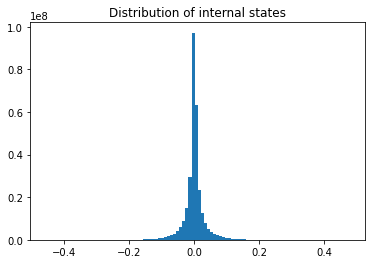

In [12]:
transient_factor = 0.1
layers = layers_save
transient = round(len(train_x) * transient_factor)

X = np.zeros((len(train_x), n_reservoir))
last = 0
for t in range(len(train_x)):
    u = train_x[t]
    layers[0].update(u)
    for i_layer in range(1, n_layers):
        layers[i_layer].update(layers[i_layer-1].x)
    X[t] = np.squeeze(layers[n_layers-1].x)
    if t % 500 == 0:
        last = round(100*t/len(train_x))
        clear_output(wait=True)
        print(f'{last}% completed')
plt.hist(X[transient:].get().flatten(), bins=100)
plt.title('Distribution of internal states')
plt.show()

#### Train linear output layer

In [13]:
model = LinearRegression().fit(X[transient:-1].get(), train_x[transient+1:].get())
train_MSE = np.mean((model.predict(X[transient:-1].get()) - train_x[transient+1:].get())**2)
print(f'Training MSE = {train_MSE}')

Training MSE = 0.010649136597709743


#### Get internal states under testing data

100% completed


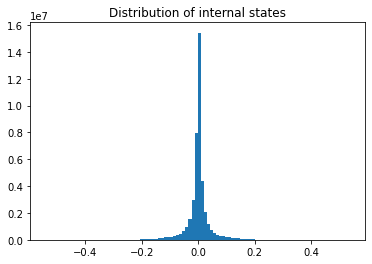

In [21]:
transient_factor = 0.7
predict = round(len(test_x) * (1 - transient_factor))
layers = layers_save

X = np.zeros((len(test_x[:predict]), n_reservoir))
last = 0
seed = []
for t in range(len(test_x[:predict])):
    u = test_x[t]
    seed.append(reverse_int_mapping[test_x[t][0].item()])
    layers[0].update(u)
    for i_layer in range(1, n_layers):
        layers[i_layer].update(layers[i_layer-1].x)
    X[t] = np.squeeze(layers[n_layers-1].x)
    if t % 100 == 0:
        last = round(100*t/len(test_x[:predict]))
        clear_output(wait=True)
        print(f'{last}% completed')
plt.hist(X.get().flatten(), bins=100)
plt.title('Distribution of internal states')
plt.show()

#### Begin feeding back in our predictions to generate new text

In [22]:
reverse_int_mapping_vals = np.asarray(list(reverse_int_mapping.keys()))
def value_to_word(val):
    idx = (np.abs(reverse_int_mapping_vals - val)).argmin().item()
    return reverse_int_mapping[list(reverse_int_mapping.keys())[idx]]

In [23]:
pred_X = np.zeros((len(test_x[-predict:]), n_reservoir))
u = np.array(model.predict(X[-1].get().reshape(1,-1))).reshape(-1,1)
generated_text = []
for t in range(len(test_x[-predict:])):
    layers[0].update(u)
    for i_layer in range(1, n_layers):
        layers[i_layer].update(layers[i_layer-1].x)
    pred_X[t] = np.squeeze(layers[n_layers-1].x)
    u = np.array(model.predict(pred_X[t].get().reshape(1,-1))).reshape(-1,1)
    generated_text.append(value_to_word(u[0][0]))
    if t==100:
        break
print('**THE NETWORK RECENTLY SAW**')
print(' '.join([x[0] for x in seed[-20:]]))
print('**AND IT GENERATED**')
print(' '.join([x[0] for x in generated_text]))

**THE NETWORK RECENTLY SAW**
during the first examinations done by malaysian investigators . law enforcement officials say that they are n't drawing any conclusions
**AND IT GENERATED**
the subsequent deletions really any former because cnn being who how more a be before in not where all other could this was new and have by in the `` to to in to to in to to in to in in to in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in


### Discussion
As we somewhat expected, the model is no better at generating text than a simple probablistic model. Whatever token is assigned to **zero** is the most generated value, whether we use *tanh*, *ReLU*, or *leaky ReLU* activation function for the internal nodes.

The likely reason is that the internal states of most nodes in ESNs are zero. These nodes offer no help to the linear output layer and so the prediction is biased toward zero.